# 損切ロジックの評価

In [13]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [14]:
import datetime
import re

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import dates as mdates

from funcs.tse import get_ticker_name_list
from modules.psar import RealtimePSAR
from modules.simulator import LosscutSimulator

In [15]:
pattern = re.compile(r".+([0-9]{4})([0-9]{2})([0-9]{2})\.xlsx")

In [19]:
name_excel = "../excel/tick_20250702.xlsx"
ticker = "7011"
# ticker = "7203"
# ticker = "8306"

m = pattern.match(name_excel)
if m:
    year = m.group(1)
    month = m.group(2)
    day = m.group(3)
else:
    year = "1970"
    month = "01"
    day = "01"
date_str = f"{year}-{month}-{day}"
df = pd.read_excel(name_excel, sheet_name=ticker)
df.index = pd.to_datetime([datetime.datetime.fromtimestamp(t) for t in df["Time"]])
df

,Time,Price
2025-07-02 09:03:02.279633,1.751415e+09,3498
2025-07-02 09:03:03.279292,1.751415e+09,3498
2025-07-02 09:03:04.292212,1.751415e+09,3502
2025-07-02 09:03:05.283896,1.751415e+09,3502
2025-07-02 09:03:06.292606,1.751415e+09,3510
...,...,...
2025-07-02 15:24:45.894840,1.751437e+09,3523
2025-07-02 15:24:46.902854,1.751437e+09,3523
2025-07-02 15:24:47.908850,1.751437e+09,3522
2025-07-02 15:24:48.909323,1.751437e+09,3522


In [20]:
simulator = LosscutSimulator(ticker, df)
profit = simulator.run()
print(f"総収益 {profit} 円")
df

総収益 -100 円


,Time,Price,MMPrice,Trend,EPupd,Duration,PSAR,Profit,Distance
2025-07-02 09:03:02.279633,1.751415e+09,3498,3498.0,0.0,0.0,0.0,0.000000,0.0,NaN
2025-07-02 09:03:03.279292,1.751415e+09,3498,3498.0,0.0,0.0,0.0,0.000000,0.0,NaN
2025-07-02 09:03:04.292212,1.751415e+09,3502,3498.0,0.0,0.0,0.0,0.000000,0.0,NaN
2025-07-02 09:03:05.283896,1.751415e+09,3502,3502.0,0.0,0.0,0.0,0.000000,0.0,NaN
2025-07-02 09:03:06.292606,1.751415e+09,3510,3502.0,0.0,0.0,0.0,0.000000,0.0,NaN
...,...,...,...,...,...,...,...,...,...
2025-07-02 15:24:45.894840,1.751437e+09,3523,3523.0,-1.0,25.0,664.0,3523.006491,1300.0,0.006491
2025-07-02 15:24:46.902854,1.751437e+09,3523,3523.0,-1.0,25.0,665.0,3522.999728,1300.0,-0.000272
2025-07-02 15:24:47.908850,1.751437e+09,3522,3523.0,1.0,0.0,0.0,3510.000000,1400.0,12.000000
2025-07-02 15:24:48.909323,1.751437e+09,3522,3522.0,1.0,0.0,1.0,3510.000260,0.0,11.999740


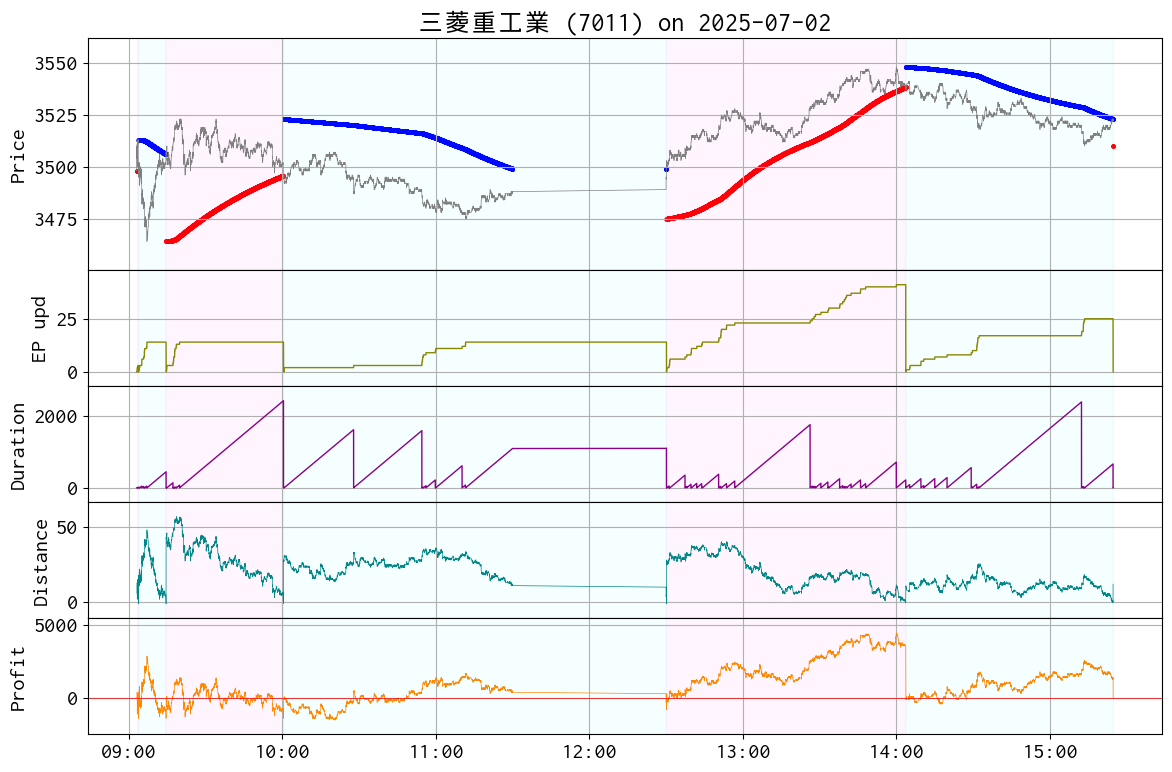

In [21]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 16
fig = plt.figure(figsize=(12, 8))
ax = dict()
n = 5
gs = fig.add_gridspec(
    n, 1, wspace=0.0, hspace=0.0, height_ratios=[2 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid()

ax[0].plot(df["Price"], color="gray", linewidth=0.5)
ser_bull = df[0 < df["Trend"]]["PSAR"]
ser_bear = df[df["Trend"] < 0]["PSAR"]

ax[0].scatter(x=ser_bull.index, y=ser_bull, s=5, c="red")
ax[0].scatter(x=ser_bear.index, y=ser_bear, s=5, c="blue")
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

ax[0].set_ylabel("Price")
dict_name = get_ticker_name_list([ticker])
ax[0].set_title(f"{dict_name[ticker]} ({ticker}) on {date_str}")

i = 1
ax[i].plot(df["EPupd"], color="#880", linewidth=1)
ax[i].set_ylabel("EP upd")

i = 2
ax[i].plot(df["Duration"], color="#808", linewidth=1)
ax[i].set_ylabel("Duration")

i = 3
ax[i].plot(df["Distance"], color="#088", linewidth=0.5)
ax[i].set_ylabel("Distance")

i = 4
ax[i].plot(df["Profit"], color="#f80", linewidth=0.5)
ax[i].axhline(0, color="red", linewidth=0.5)
ax[i].set_ylabel("Profit")

for i in range(n):
    x = df.index
    y = df["Trend"]
    ax[i].fill_between(
        x,
        0,
        1,
        where=y > 0,
        color="magenta",
        alpha=0.04,
        transform=ax[i].get_xaxis_transform(),
    )
    ax[i].fill_between(
        x,
        0,
        1,
        where=y < 0,
        color="cyan",
        alpha=0.04,
        transform=ax[i].get_xaxis_transform(),
    )

plt.tight_layout()
plt.savefig(f"screenshots/losscut_eval_{ticker}_{date_str}.png")
plt.show()